In [1]:
import pandas as pd
import boto3
import sagemaker
import json
import joblib
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import numpy as np
import pyarrow
from math import radians, sin, cos, sqrt, atan2
import time
import io
from io import StringIO
import base64
import pprint
import re
from sagemaker.image_uris import retrieve

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
from scipy.stats import norm
import statsmodels.api as sm

In [3]:
pip install s3fs

  Using cached fsspec-2024.3.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached botocore-1.31.64-py3-none-any.whl.metadata (6.1 kB)
Using cached fsspec-2024.3.1-py3-none-any.whl (171 kB)
Using cached botocore-1.31.64-py3-none-any.whl (11.3 MB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
ERROR: Cannot uninstall fsspec 2023.6.0, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps fsspec==2023.6.0'.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pdpbox

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [7]:
sess = sagemaker.Session()
write_bucket = sess.default_bucket()
write_prefix = "search-algorithm-demo"

region = sess.boto_region_name
s3_client = boto3.client("s3", region_name=region)
sm_client = boto3.client("sagemaker", region_name=region)
sm_runtime_client = boto3.client("sagemaker-runtime")
sm_autoscaling_client = boto3.client("application-autoscaling")

sagemaker_role = sagemaker.get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [8]:
def read_glue_table(database_name, table_name):
    # Create Glue client
    glue_client = boto3.client('glue')

    # Get the Glue table metadata
    response = glue_client.get_table(DatabaseName=database_name, Name=table_name)
    location = response['Table']['StorageDescriptor']['Location']

    # Read data from the Glue table into a Pandas DataFrame
    try:
        df = pd.read_parquet(location)
        if df.empty:
            raise ValueError("CSV file is empty")
        return df
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return None

In [9]:
df_nl_tutor = read_glue_table('algorithm_search', 'nl_tutor')
df_nl_student = read_glue_table('algorithm_search', 'nl_student')
df_nl_relations = read_glue_table('algorithm_search', 'student_tutor')

df = df_nl_relations.merge(df_nl_tutor, how='left', on=['tutor'])
df = df.rename(columns={'registration_date': 'tutor_registration_date', 'city': 'tutor_city', 'heard_about': 'tutor_heard_about','latitude': 'tutor_latitude',
                       'longitude': 'tutor_longitude'}) 
df = df.merge(df_nl_student, how='left', left_on='student', right_on='student_id')
df = df.rename(columns={'city': 'student_city', 'heard_about': 'student_heard_about',
                        'latitude': 'student_latitude', 'longitude': 'student_longitude'})
df = df.drop(columns = {'last_active_at_x', 'country_x', 'state_x', 'last_active_at_y', 'country_y', 'state_y', 'student_id', 'registration_date'})

In [10]:
df['student'] = df['student'].astype('str')

df['tutor'] = df['tutor'].astype('str')

df['course'] = df['course'].astype('str')

df['matched'] = df['matched'].astype('bool')

df['tutor_city'] = df['tutor_city'].astype('str')

df['tutor_accepts_new_students'] = df['tutor_accepts_new_students'].astype('bool')

df['tutor_can_teach_online'] = df['tutor_can_teach_online'].astype('bool')

df['tutor_has_availability'] = df['tutor_has_availability'].astype('bool')

df['tutor_course_offerings_count'] = pd.to_numeric(df['tutor_course_offerings_count'], errors='coerce')
zero_count_rows = df[df['tutor_course_offerings_count'].isna()]
count_courses_by_tutor = df.groupby('tutor')['course'].nunique()
df.loc[zero_count_rows.index, 'tutor_course_offerings_count'] = zero_count_rows['tutor'].map(count_courses_by_tutor)
df['tutor_course_offerings_count'] = df['tutor_course_offerings_count'].astype('int64')

df['tutor_intake_date'] = pd.to_datetime(df['tutor_intake_date'])
df['tutor_intake_date'] = df['tutor_intake_date'].dt.tz_localize(None)

df['student_city'] = df['student_city'].astype('str')

df['has_online_lessons'] = df['has_online_lessons'].astype('category')

df['has_package'] = df['has_package'].astype('bool')

df['tutor_type'] = df['tutor_type'].astype('category')

df['previous_lesson'] = df['previous_lesson'].astype('bool')

In [11]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6371 * c  # Radius of the Earth in kilometers

    return distance

#Only cases for that country
df.replace('nan', np.nan, inplace=True)
df = df.dropna(subset=['student_city', 'tutor_city'])
df = df.drop_duplicates()

#Distance
df['distance'] = np.where(df.apply(lambda row: haversine(row['student_latitude'], row['student_longitude'], row['tutor_latitude'], row['tutor_longitude']), axis=1) > df['tutor_max_travel_distance'], 0,
                         round(df.apply(lambda row: haversine(row['student_latitude'], row['student_longitude'], row['tutor_latitude'], row['tutor_longitude']), axis=1), 2))        

#Days since intake when matching
df['tutor_intake_date'] = pd.to_datetime(df['tutor_intake_date'])
df['tutor_days_since_intake'] = np.where(df['tutor_intake_date'].notnull(), (df['matching_date'] - df['tutor_intake_date']).dt.days, 10000)

#Fill missing value
df['student_heard_about'] = df['student_heard_about'].fillna("Not provided")
df['tutor_first_lesson_date'] = df['tutor_first_lesson_date'].fillna(df.matching_date)
df['tutor_manual_weight'] = df['tutor_manual_weight'].fillna(1.0)


#Process new variables
df['tutor_days_to_first_lesson'] = (df['tutor_first_lesson_date'] - df['tutor_registration_date']).dt.days

df['avg_lesson_per_student'] = np.where((df['tutor_total_accepted_lessons'] != 0) & (df['tutor_previous_number_of_students'] != 0), df['tutor_total_accepted_lessons'].astype(float) / df['tutor_previous_number_of_students'].astype(float), 1)

df['tutor_actual_cancellations'] = df['tutor_total_appointment_requests'] - df['tutor_total_accepted_lessons'] - df['tutor_cancellations']
df['tutor_actual_cancellations'] = df['tutor_actual_cancellations'].apply(lambda x: max(0, x))

df['lessons_per_relation'] = np.where(df['number_of_relations'] > 0, df['tutor_total_accepted_lessons'] / df['number_of_relations'], 0)

In [12]:
df = df[((df['tutor_total_appointment_requests'] != 0) & (df['tutor_average_duration'] != 0)) | ((df['tutor_total_appointment_requests'] == 0) & (df['tutor_average_duration'] == 0) & (df['tutor_previous_number_of_students'] == 0))]
df = df.dropna(subset=['has_online_lessons'])
df = df.loc[df.groupby(['student', 'tutor', 'course', 'matched'])['has_online_lessons'].idxmax()].reset_index(drop=True)
df = df.loc[df.groupby(['student', 'tutor', 'course', 'matched'])['matching_date'].idxmax()].reset_index(drop=True)

In [13]:
#multiplier to process the old ranking formula
df['first_multiplier_lessons'] = (np.where(df['tutor_total_accepted_lessons'] > 50, 2, 1)) * \
                                  (np.where(df['tutor_total_accepted_lessons'] > 70, 2, 1)) * \
                                  (np.where(df['tutor_total_accepted_lessons'] > 100, 2, 1)) * \
                                  (np.where(df['tutor_total_accepted_lessons'] > 140, 2, 1)) * \
                                  (np.where(df['tutor_total_accepted_lessons'] > 210, 2, 1)) * \
                                  (np.where(df['tutor_total_accepted_lessons'] > 280, 2, 1)) * \
                                  (np.where(df['tutor_total_accepted_lessons'] > 330, 2, 1)) * \
                                  (np.where(df['tutor_total_accepted_lessons'] > 400, 2, 1))

conditions = [
    (df['tutor_previous_number_of_students'] == 0) & (df['number_of_relations'] < 3),
    (df['tutor_previous_number_of_students'] == 1) & (df['tutor_total_accepted_lessons'] == 1),
    (df['tutor_previous_number_of_students'] != 0) 
]
choices = [
    4,
    1,
    (((df['tutor_total_accepted_lessons'] / df['tutor_previous_number_of_students']) ** 2) / (df['tutor_previous_number_of_students'] ** 2.2)) * df['first_multiplier_lessons']
]
default = 0

df['first_multiplier'] = np.select(conditions, choices, default)
df['first_multiplier'] = np.sqrt(df['first_multiplier'])

df['second_multiplier'] = np.where(df['number_of_relations'] > 0, (1 + df['tutor_previous_number_of_students'])/df['number_of_relations'], 1.4)
df['third_multiplier'] = np.where(df['tutor_has_availability'] == True, 1.2, 0.8)
df['fourth_multiplier'] = np.where((df['tutor_previous_number_of_students'] == 0) & (df['number_of_relations'] < 3) & (df['tutor_days_since_intake'] < 38), 8, 1)
df['offline_multiplier'] = 2.2 * np.where(df['tutor_type'] == 1, 1, 1.3) + 1

#Ranking score
df['tutor_manual_weight'] = df['tutor_manual_weight'].fillna(1)
df['online_rank_score'] = df['first_multiplier'] * df['second_multiplier'] * df['third_multiplier'] * df['fourth_multiplier'] * df['tutor_manual_weight']
df['offline_rank_score'] = df['first_multiplier'] * df['second_multiplier'] * df['third_multiplier'] * df['fourth_multiplier'] * df['tutor_manual_weight']/df['offline_multiplier']
df['old_formula'] = np.where(df['has_online_lessons'] != 1, df['offline_rank_score'], df['online_rank_score']) 

#Drop unecessary columns
df = df.drop(columns=['tutor_registration_date', 'tutor_first_lesson_date', 'matching_date', 'student_longitude', 'student_latitude', 'tutor_latitude', 'tutor_longitude', 'tutor_intake_date', 'tutor_manual_weight', 'student_heard_about'])
df = df.drop(columns=['first_multiplier', 'first_multiplier_lessons', 'second_multiplier', 'third_multiplier', 'fourth_multiplier', 'offline_multiplier', 'online_rank_score', 'offline_rank_score', 'tutor_days_since_intake'])
df = df.drop(columns=['tutor_city', 'student_city', 'tutor_total_appointment_requests', 'student_previous_lessons', 'student_total_accepted_intro_lessons', 'has_online_lessons', 'has_package'])
df = df.drop(columns=['tutor_course_appointment_requests', 'student_total_intro_requests', 'tutor_course_previous_number_of_students', 'tutor_cancellations', 'number_of_relations', 'student_tutor_has_intro'])

In [14]:
instrumental_formula = 'matched ~ student_average_duration + created_deals + availabile_hours + online_lesson_rate:tutor_can_teach_online + tutor_accepts_new_students + tutor_max_travel_distance:distance + tutor_course_offerings_count + old_formula + tutor_type + previous_lesson'

probit_model = sm.GLM.from_formula(formula=instrumental_formula, data=df, family=sm.families.Binomial(link=sm.families.links.Probit()))
probit_result = probit_model.fit()
predicted_probabilities = probit_result.predict(df)
probit_lp = probit_result.fittedvalues
mills_ratio = np.exp(-0.5 * probit_lp ** 2) / (np.sqrt(2 * np.pi) * predicted_probabilities)
inverse_mills_ratio = 1 / mills_ratio
df['inverse_mills_ratio'] = inverse_mills_ratio

In [15]:
import sklearn
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import PoissonRegressor, ElasticNet
from statsmodels.genmod.families import Poisson
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score, recall_score, accuracy_score
from sklearn.inspection import PartialDependenceDisplay
from xgboost import XGBRegressor, XGBClassifier
from xgboost import callback
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

In [16]:
###Uncomment to remove outliers###
##If you no longer want to run code without outliers, run the above code from the top again##

mean = np.mean(df['tutor_student_number_of_lessons'])
std_dev = 2.5 * np.std(df['tutor_student_number_of_lessons'])
df = df[df['tutor_student_number_of_lessons'].between(mean - std_dev, mean + std_dev)]

X = df.drop(columns=['tutor_student_number_of_lessons', 'student', 'tutor', 'course', 'matched'])
y = df['tutor_student_number_of_lessons']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 2503)
kf = KFold(n_splits=5, shuffle=True, random_state=1900561252)
folds = []
for train_index, val_index in kf.split(X_train):
    folds.append((train_index, val_index))

def poisson_loss(y_true, y_pred):
    return np.mean(y_pred - y_true * np.log(y_pred))

def rmse_scorer(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

scorer = make_scorer(rmse_scorer, greater_is_better=False)

##For testing whether count data is better
#scorer = make_scorer(poisson_loss, greater_is_better = False)

In [ ]:
####                             ####
###                               ###
##                                 ##
#           Random Forest           #
##                                 ##
###                               ###
####                             ####

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['tutor_type'])
    ],
    remainder='passthrough'
)

# Define parameter grid for RandomForestRegressor
param_grid_rf = {
    'rf_regressor__n_estimators': [500],  
    'rf_regressor__max_features': list(range(1, 29))
}

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf_regressor', RandomForestRegressor())
])

# Merge parameter grids
param_grid = {**param_grid_rf}

# Initialize RandomizedSearchCV
rf_model_tune = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=folds, scoring=scorer, verbose=1, n_jobs=2)

# Fit the model
rf_model_tune.fit(X_train, y_train)

# Get results
rf_results = pd.DataFrame(rf_model_tune.cv_results_)

# Sort the results DataFrame by a suitable metric, for example, mean_test_score
rf_sorted_results = rf_results.sort_values(by='mean_test_score', ascending=False)
print(rf_sorted_results.head(1))

# Get the preprocessor from the pipeline
rf_preprocessor = rf_model_tune.best_estimator_.named_steps['preprocessor']

# Get the names of transformed features
rf_transformed_feature_names = rf_preprocessor.get_feature_names_out()

# Get feature importances from the trained RandomForestRegressor
rf_feature_importances = rf_model_tune.best_estimator_.named_steps['rf_regressor'].feature_importances_

# Create a DataFrame to store feature importance along with their names
rf_feature_importance_df = pd.DataFrame({'Feature': rf_transformed_feature_names, 'Importance': rf_feature_importances})

# Sort features based on importance scores
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False)

# Display feature importance DataFrame
print(rf_feature_importance_df)

# Retrieve tuning results
rf_results = rf_model_tune.cv_results_

# Extract relevant information
mean_test_scores = rf_results['mean_test_score']
std_test_scores = rf_results['std_test_score']
params = rf_results['params']

# Plot the scores of all estimators
plt.figure(figsize=(10, 6))
for i in range(len(params)):
    plt.errorbar(i, mean_test_scores[i], yerr=std_test_scores[i], fmt='o', label=str(params[i]))

plt.xticks(range(len(params)), [str(param) for param in params], rotation=90)
plt.xlabel('Estimator')
plt.ylabel('Mean Test Score')
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 28 candidates, totalling 140 fits


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 5 folds for each of 66 candidates, totalling 330 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.393e+04, tolerance: 1.566e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.206e+04, tolerance: 1.514e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

-3.9948701469787706
num__old_formula inverse_mills_ratio: 0.08272602892411877
num__lessons_per_relation old_formula: -0.06671463480578495
num__distance old_formula: 0.05298791840886522
num__student_average_duration: -0.0527469375013916
num__tutor_type: 0.0482093341491945
num__availabile_hours: -0.04792929134545385
num__lessons_per_relation inverse_mills_ratio: 0.04761437237691093
num__avg_lesson_per_student old_formula: -0.047296160873161436
num__availabile_hours tutor_days_to_first_lesson: -0.04611329253952096
num__distance lessons_per_relation: 0.04513643639085308
num__tutor_max_travel_distance inverse_mills_ratio: -0.04262810566444305
num__inverse_mills_ratio: -0.042053083198629014
num__tutor_total_intro_requests: -0.04179398414731821
num__availabile_hours inverse_mills_ratio: -0.041516138559675946
num__created_deals online_lesson_rate: 0.041186715162584334
num__tutor_course_offerings_count tutor_type: 0.040907107603878265
num__tutor_previous_number_of_students tutor_days_to_first_l

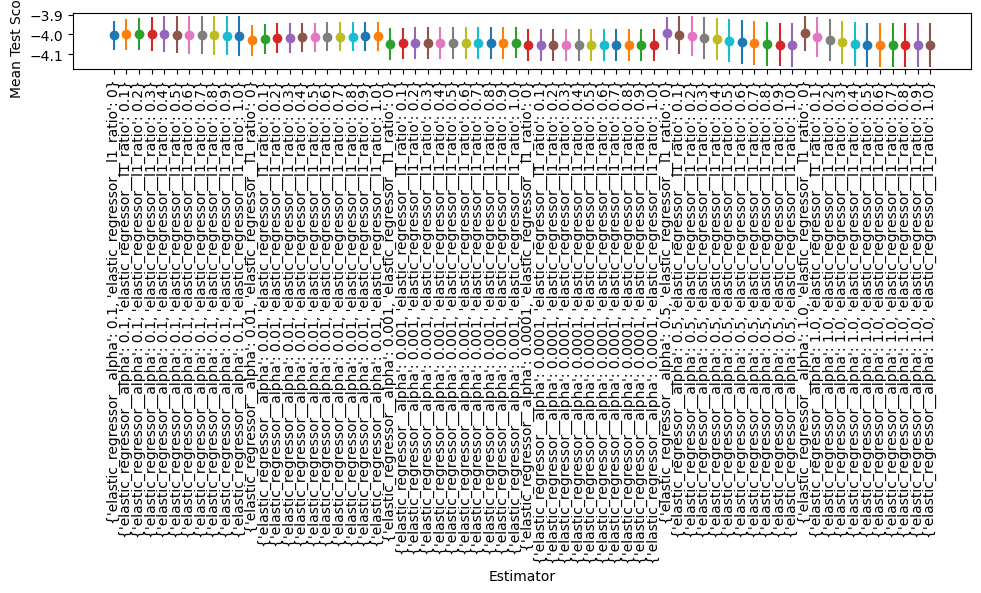

In [28]:
####                             ####
###                               ###
##                                 ##
#   Regularized Linear Regression   #
##                                 ##
###                               ###
####                             ####

# Define feature
numerical_feature_names = ['tutor_total_accepted_lessons','tutor_course_accepted_lessons', 'tutor_average_duration', 'student_average_duration', 
                           'created_deals', 'tutor_previous_number_of_students', 'tutor_total_intro_requests', 'tutor_total_accepted_intro_lessons', 
                           'availabile_hours', 'median_response_time', 'intros_leading_to_lesson', 'online_lesson_rate', 
                           'tutor_max_travel_distance', 'tutor_course_offerings_count', 'distance', 'tutor_days_to_first_lesson', 'avg_lesson_per_student', 
                           'tutor_actual_cancellations', 'lessons_per_relation', 'old_formula', 'inverse_mills_ratio']
boolean_feature_names = ['previous_lesson', 'tutor_accepts_new_students', 'tutor_can_teach_online', 'tutor_has_availability']

categorical_feature_names = ['tutor_type']

# Define preprocessing steps for numerical features
numerical_preprocessor = Pipeline([
    ('interaction', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),  # Include interaction terms up to second degree
    ('variance_threshold', VarianceThreshold()),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical features
categorical_preprocessor = Pipeline([
    ('cat', OneHotEncoder())
])

# Combine the two preprocessors using make_column_transformer
preprocessor_elastic = ColumnTransformer(
    transformers=[
        ('cat', categorical_preprocessor, categorical_feature_names),
        ('num', numerical_preprocessor, numerical_feature_names + categorical_feature_names), 
    ],
    remainder='passthrough'
)

# Define ElasticNet regressor
elastic_regressor = ElasticNet(max_iter=3500, random_state=1575)

# Create pipeline
pipeline_elastic = Pipeline(steps=[
    ('preprocessor', preprocessor_elastic),
    ('elastic_regressor', elastic_regressor)
])

# Define parameter grid for ElasticNet
param_grid_elastic_net = {
    'elastic_regressor__alpha': [0.1, 0.01, 0.001, 0.0001, 0.5, 1.0],
    'elastic_regressor__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

# Define parameter grid
param_grid = {**param_grid_elastic_net}

# Initialize GridSearchCV
elastic_net_model_tune = GridSearchCV(estimator=pipeline_elastic, 
                                      param_grid=param_grid, 
                                      cv=folds, 
                                      scoring=scorer, 
                                      verbose=1, 
                                      n_jobs=4, 
                                      error_score='raise')

# Fit the model
elastic_net_model_tune.fit(X_train, y_train)

# Get the best estimator from the GridSearchCV
elastic_net_model = elastic_net_model_tune.best_estimator_

test_score = elastic_net_model_tune.best_score_
print(test_score)

# Assuming you have a DataFrame called df with your original data
original_feature_names = df.columns

# Extract the preprocessor from the best estimator
preprocessor = elastic_net_model.named_steps['preprocessor']

# Extract the model from the best estimator
model = elastic_net_model.named_steps['elastic_regressor']

# Get the names of the transformed features
transformed_feature_names = preprocessor.get_feature_names_out()

# Map the coefficients back to the original feature names
coef_mapping = dict(zip(transformed_feature_names, model.coef_))
sorted_coef_mapping = {k: v for k, v in sorted(coef_mapping.items(), key=lambda item: abs(item[1]), reverse=True)}

for feature_name, coefficient in sorted_coef_mapping.items():
    print(f"{feature_name}: {coefficient}")
    
intercept = elastic_net_model.named_steps['elastic_regressor'].intercept_
print("Intercept:", intercept)

# Retrieve tuning results
elastic_net_results = elastic_net_model_tune.cv_results_

# Extract relevant information
mean_test_scores = elastic_net_results['mean_test_score']
std_test_scores = elastic_net_results['std_test_score']
params = elastic_net_results['params']

# Plot the scores of all estimators
plt.figure(figsize=(10, 6))
for i in range(len(params)):
    plt.errorbar(i, mean_test_scores[i], yerr=std_test_scores[i], fmt='o', label=str(params[i]))

plt.xticks(range(len(params)), [str(param) for param in params], rotation=90)
plt.xlabel('Estimator')
plt.ylabel('Mean Test Score')
plt.tight_layout()
plt.show()

In [27]:
####                             ####
###                               ###
##                                 ##
#      Zero-Inflated Count Model    #
##                                 ##
###                               ###
####                             ####

train_data = pd.concat([X_train, pd.DataFrame(y_train, columns=['tutor_student_number_of_lessons'])], axis=1)
formula = 'tutor_student_number_of_lessons ~ tutor_total_accepted_lessons + tutor_course_accepted_lessons + tutor_average_duration + student_average_duration + created_deals + tutor_previous_number_of_students + tutor_total_intro_requests + tutor_total_accepted_intro_lessons + availabile_hours + median_response_time + intros_leading_to_lesson + online_lesson_rate + tutor_max_travel_distance + tutor_course_offerings_count + tutor_days_to_first_lesson + distance + avg_lesson_per_student + tutor_actual_cancellations + tutor_can_teach_online + tutor_has_availability + old_formula + inverse_mills_ratio + previous_lesson + tutor_accepts_new_students + tutor_type'

model_count = sm.GLM.from_formula(formula, data=train_data, family=sm.families.NegativeBinomial())
result_count = model_count.fit()

# Predicting on the training data
y_pred = result_count.predict(train_data)

# Calculating RMSE
rmse = rmse_scorer(train_data['tutor_student_number_of_lessons'], y_pred)
print(rmse)

#Poisson = poisson_loss(train_data['tutor_student_number_of_lessons'], y_pred)
#print(f"Poisson: {Poisson}")

print(result_count.params)

/opt/conda/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


4.010946592998558
Intercept                             1.462934e+00
tutor_can_teach_online[T.True]        5.371406e-02
tutor_has_availability[T.True]        7.169547e-02
previous_lesson[T.True]              -2.278749e-01
tutor_accepts_new_students[T.True]   -1.159931e-02
tutor_type[T.Decimal('2')]            1.084239e-01
tutor_type[T.Decimal('3')]            1.359279e-01
tutor_total_accepted_lessons          7.731527e-04
tutor_course_accepted_lessons         9.124541e-04
tutor_average_duration               -2.234211e-04
student_average_duration             -4.454490e-03
created_deals                         1.719689e-03
tutor_previous_number_of_students     3.729803e-02
tutor_total_intro_requests           -5.878487e-03
tutor_total_accepted_intro_lessons    1.512600e-02
availabile_hours                     -1.826097e-03
median_response_time                  7.317783e-07
intros_leading_to_lesson             -3.262195e-02
online_lesson_rate                   -5.026272e-02
tutor_max_tra

In [18]:
####                             ####
###                               ###
##                                 ##
#    Two-stage XGBoost correction   #
##                                 ##
###                               ###
####                             ####

test_X = df.drop(columns=['tutor_student_number_of_lessons', 'student', 'tutor', 'course', 'matched', 'inverse_mills_ratio'])
test_y = df['matched']
test_y_final = df['tutor_student_number_of_lessons']
test_y_final = test_y_final.reset_index(drop=True)

class EarlyStoppingCallback(callback.TrainingCallback):
    def __init__(self, rounds_without_improvement):
        super().__init__()
        self.rounds_without_improvement = rounds_without_improvement
        self.best_score = float('inf')
        self.rounds_since_improvement = 0

    def callback(self, env):
        if 'validation_0' in env.evaluation_result_list:
            validation_loss = env.evaluation_result_list['validation_0']['logloss']
            if validation_loss < self.best_score:
                self.best_score = validation_loss
                self.rounds_since_improvement = 0
            else:
                self.rounds_since_improvement += 1
                if self.rounds_since_improvement >= self.rounds_without_improvement:
                    return True
        return False

# Initialize lists to store predictions from each stage
second_stage_predictions = []
tests = []

# Create StratifiedKFold object
test_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1900561252)

# Initialize a list to store RMSE scores for each fold
rmse_scores = []
poisson_scores = []

for train_index, val_index in test_skf.split(test_X, test_y):
    #First stage model
    xgb_preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), ['tutor_type'])
        ],
        remainder='passthrough'
    )
    
    test_pipeline_xgb_best = Pipeline(steps=[
        ('preprocessor', xgb_preprocessor),
        ('xgb_regressor', XGBClassifier(
            n_estimators=1100,
            learning_rate=0.05,
            max_depth=2,
            colsample_bytree=0.75,
            callbacks=[EarlyStoppingCallback(rounds_without_improvement=500)]
        ))
    ])

    # Fit the probability
    test_pipeline_xgb_best.fit(test_X.iloc[train_index], test_y.iloc[train_index])

    test = test_pipeline_xgb_best.predict(test_X.iloc[train_index])

    # Define the threshold
    threshold = 0.808782

    # Predict probabilities
    probabilities = test_pipeline_xgb_best.predict_proba(test_X.iloc[val_index])[:, 1]
    tests.extend(probabilities)


    # Apply thresholding
    matched_prob_val = (probabilities >= threshold).astype(int)
    
    #Second stage model
    test_final_pipeline_xgb_best = Pipeline(steps=[
        ('preprocessor', xgb_preprocessor),
        ('xgb_regressor', XGBRegressor(
        n_estimators=1100,
        learning_rate=0.03,
        max_depth=2,
        colsample_bytree=0.75,
        callbacks=[EarlyStoppingCallback(rounds_without_improvement=500)]
        ))
    ])
    
    test_final_pipeline_xgb_best.fit(test_X.iloc[train_index], test_y_final[train_index])

    second_stage_prediction = test_final_pipeline_xgb_best.predict(test_X.iloc[val_index])

    second_stage_predictions.extend(second_stage_prediction)
    
    # Step 5: Multiply first stage prediction with the second stage prediction
    combined_prediction = matched_prob_val * second_stage_prediction

    # Step 6: Calculate RMSE using the actual number of lessons
    actual_y = test_y_final[val_index]
    rmse_score = np.sqrt(mean_squared_error(actual_y, combined_prediction))
    rmse_scores.append(rmse_score)

mean_rmse_score = np.mean(rmse_scores)
print(mean_rmse_score)

# Assuming tests is the list containing your test results
tests_df = pd.DataFrame(tests, columns=['probabilities'])

# Generate summary statistics
summary_stats = tests_df.describe()

# Print summary statistics
print(summary_stats)

4.268535851942051
       probabilities
count   16717.000000
mean        0.808782
std         0.222194
min         0.035035
25%         0.647748
50%         0.916816
75%         0.998066
max         0.999999


In [21]:
####                             ####
###                               ###
##                                 ##
#        K-Nearest Neighbors        #
##                                 ##
###                               ###
####                             ####

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['tutor_type'])
    ],
    remainder='passthrough'
)

# Define parameter grid for K-nearest neighbors
param_grid_knn = {
    'knn_regressor__n_neighbors': np.linspace(1, 100, num=100, dtype=int)
}

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn_regressor', KNeighborsClassifier())
])

# Initialize GridSearchCV
knn_model_tune = GridSearchCV(estimator=pipeline, param_grid=param_grid_knn, cv=folds, scoring = scorer, verbose=0, n_jobs=3)

# Fit the model
knn_model_tune.fit(X_train, y_train)

GridSearchCV(cv=[(array([    0,     3,     5, ..., 11698, 11699, 11700]),
                  array([    1,     2,     4, ..., 11687, 11688, 11693])),
                 (array([    0,     1,     2, ..., 11698, 11699, 11700]),
                  array([    9,    16,    29, ..., 11689, 11695, 11696])),
                 (array([    1,     2,     3, ..., 11697, 11698, 11699]),
                  array([    0,    25,    27, ..., 11690, 11692, 11700])),
                 (array([    0,     1,     2, ..., 11698, 11699, 11700]),
                  array([    8,    11,    12, ..., 11675, 11691, 11694])),
                 (array([    0,     1,     2, ..., 11695...
             param_grid={'knn_regressor__n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])},
             scoring=make_scorer(rmse_scorer, greater_is_better=False))

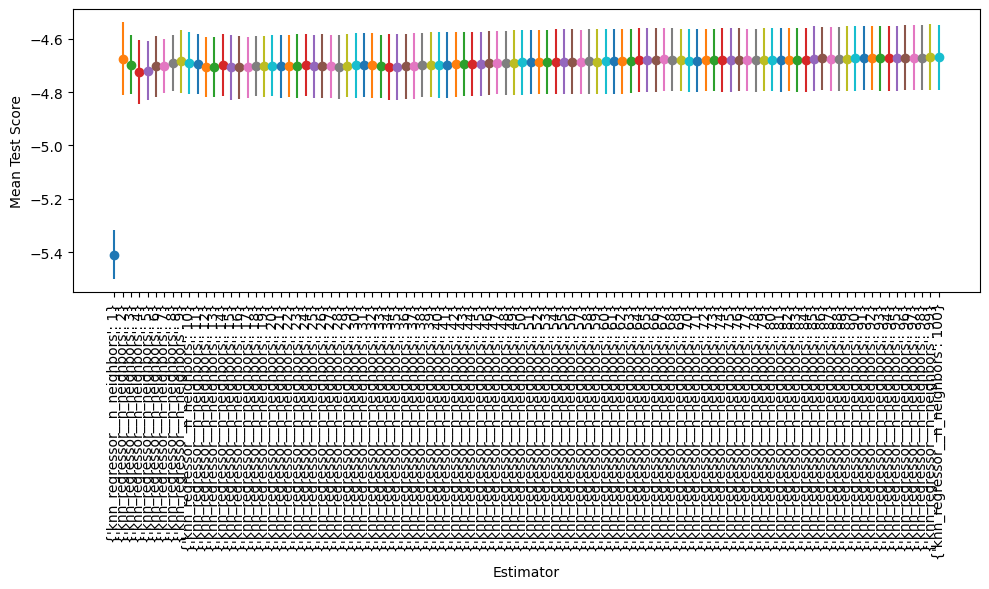

3.9442765746338537


In [23]:
# Retrieve tuning results
knn_results = knn_model_tune.cv_results_

# Extract relevant information
mean_test_scores = knn_results['mean_test_score']
std_test_scores = knn_results['std_test_score']
params = knn_results['params']

# Plot the scores of all estimators
plt.figure(figsize=(10, 6))
for i in range(len(params)):
    plt.errorbar(i, mean_test_scores[i], yerr=std_test_scores[i], fmt='o', label=str(params[i]))

plt.xticks(range(len(params)), [str(param) for param in params], rotation=90)
plt.xlabel('Estimator')
plt.ylabel('Mean Test Score')
plt.tight_layout()
plt.show()

best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn_regressor', KNeighborsRegressor(n_neighbors = 40))
])

best_pipeline.fit(X_train, y_train)

y_pred = best_pipeline.predict(X_train)

rmse = rmse_scorer(y_train, y_pred)
print(rmse)

#Poisson = poisson_loss(y_train, y_pred)
#print(f"Poisson: {Poisson}")

In [ ]:
####                             ####
###                               ###
##                                 ##
#           Neural Network          #
##                                 ##
###                               ###
####                             ####

# Define feature
numerical_feature_names = ['tutor_total_accepted_lessons','tutor_course_accepted_lessons', 'tutor_average_duration', 'student_average_duration', 
                           'created_deals', 'tutor_previous_number_of_students', 'tutor_total_intro_requests', 'tutor_total_accepted_intro_lessons', 
                           'availabile_hours', 'median_response_time', 'intros_leading_to_lesson', 'online_lesson_rate', 
                           'tutor_max_travel_distance', 'tutor_course_offerings_count', 'distance', 'tutor_days_to_first_lesson', 'avg_lesson_per_student', 
                           'tutor_actual_cancellations', 'lessons_per_relation', 'old_formula', 'inverse_mills_ratio']
boolean_feature_names = ['previous_lesson', 'tutor_accepts_new_students', 'tutor_can_teach_online', 'tutor_has_availability']

categorical_feature_names = ['tutor_type']

# Define preprocessing steps for numerical features
numerical_preprocessor = Pipeline([
    ('interaction', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),  # Include interaction terms up to second degree
    ('variance_threshold', VarianceThreshold()),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical features
categorical_preprocessor = Pipeline([
    ('cat', OneHotEncoder())
])

# Combine the two preprocessors using make_column_transformer
preprocessor_neural = ColumnTransformer(
    transformers=[
        ('cat', categorical_preprocessor, categorical_feature_names),
        ('num', numerical_preprocessor, numerical_feature_names + categorical_feature_names), 
    ],
    remainder='passthrough'
)

# Define parameter grid for Neural Network
param_grid_neural = {
    'neural_regressor__hidden_layer_sizes': np.linspace(10, 100, num = 10, dtype = int),  
    'neural_regressor__activation': ['identity', 'logistic', 'relu'],
    'neural_regressor__solver': ['sgd', 'adam'],  
    'neural_regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],  
    'neural_regressor__batch_size': [16, 32, 64, 128, 256, 'auto'],  
    'neural_regressor__learning_rate': ['constant'],
    'neural_regressor__learning_rate_init': [0.001, 0.01, 0.1, 0.5],  
    'neural_regressor__max_iter': [100, 200, 300, 400, 500],  
    'neural_regressor__solver': ['sgd']
}


# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_neural),
    ('neural_regressor', MLPRegressor())
])

# Merge parameter grids
param_grid = {**param_grid_neural}

# Initialize RandomizedSearchCV
neural_model_tune = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid_neural, n_iter=150, cv=folds, scoring=scorer, verbose=2, n_jobs=1, random_state=42)

# Fit the model
neural_model_tune.fit(X_train, y_train)

In [ ]:
# Extract results from RandomizedSearchCV
results = neural_model_tune.cv_results_

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot results for each hyperparameter
plt.figure(figsize=(12, 8))


# Plot colsample_bytree
plt.subplot(2, 2, 4)
sns.boxplot(x='param_neural_regressor__alpha', y='mean_test_score', data=results_df)
plt.title('colsample_bytree')
plt.xticks(fontsize=6)

plt.subplot(2, 2, 1)
sns.boxplot(x='param_neural_regressor__batch_size', y='mean_test_score', data=results_df)
plt.title('colsample_bytree')
plt.xticks(fontsize=6)

plt.subplot(2, 2, 2)
sns.boxplot(x='param_neural_regressor__learning_rate_init', y='mean_test_score', data=results_df)
plt.title('colsample_bytree')
plt.xticks(fontsize=6)

plt.subplot(2, 2, 3)
sns.boxplot(x='param_neural_regressor__max_iter', y='mean_test_score', data=results_df)
plt.title('colsample_bytree')
plt.xticks(fontsize=6)

plt.tight_layout()
plt.show()

In [26]:
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_neural),
    ('neural_regressor', MLPRegressor(
        hidden_layer_sizes = 60, 
        activation = "identity", 
        solver = "sgd", 
        alpha = 1.0,
        batch_size = 32,
        learning_rate = "constant",
        learning_rate_init = 0.001,
        max_iter = 100
    ))
])

best_pipeline.fit(X_train, y_train)

y_train_pred_neural = best_pipeline.predict(X_train)
rmse_xgb = rmse_scorer(y_train, y_train_pred_neural)
print("RMSE for Neural:", rmse_xgb)

RMSE for Neural: 3.962046331116185


In [ ]:
### For predicting probability:
#remainder__created_deals    0.336321
#remainder__availabile_hours    0.166190
#remainder__online_lesson_rate    0.152716
#remainder__tutor_total_intro_requests    0.092951
#remainder__previous_lesson    0.044431
#remainder__intros_leading_to_lesson    0.039794
#remainder__lessons_per_relation    0.033609
#remainder__distance    0.024363
#remainder__old_formula    0.020331
#remainder__student_average_duration    0.020151
#remainder__tutor_course_accepted_lessons    0.019636
#remainder__tutor_average_duration    0.017743
#remainder__median_response_time    0.016535
#remainder__tutor_course_offerings_count    0.015230